## Homework 05: A Mixture of Five
##### By Kevin Liu

Since Wiggins left the Holmes lab in protest to his poor pay as a graduate student, we are left to deal with one of his analyses of a single cell RNA-seq experiment. One mystery we were asked to solve was the k-means clustering results that Wiggins performed, where the clustering of the data seemed to have poor performance despite having five clearly defined clusters that is apparent to the naked eye.

After grabbing our (much needed) coffee, we are ready to solve this mystery. Lets first load in some modules that we expect to use and take a look at the raw data before digging deeper.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import scipy.spatial.distance as dis
from scipy.special import logsumexp

%matplotlib inline

In [2]:
! head w05-data.tbl

#cell        type      caraway         kiwi
0               0           25         1246
1               2          450          549
2               1         1065         1022
3               0           13         3237
4               2          334          470
5               2          248          107
6               3           43           11
7               2          306          332
8               3           31           73


Next, lets define some functions to read in the data and visualize the clustered data.

In [3]:
def read_data(infile):
    '''
    This function was provided in the pset hints.
    Reads in the pset data and returns all relevant parameters.
    
    Output:
       ctype[0..N-1]: cell types 0..Q-1 for each cell i.
       data[i,g]    : array of count data; rows = cells i; cols = genes g.
       N            : number of cells (rows of the data file).
       G            : number of genes (cols of the data file, after the first).
       Q            : number of cell types.
    '''
    ctype = []
    data  = []
    with open(infile) as f:
        for line in f:
            if line[0] == '#': continue
            fields = line.split()
            ctype.append(int(fields[1]))
            data.append([int(fields[2]), int(fields[3])])
    ctype = np.array(ctype)
    data  = np.array(data)
    N, G  = np.shape(data)
    Q     = np.max(ctype) + 1
    return ctype, data, N, G, Q


def visualize_data(data, mu, C, log_scale = False, log_labs = False):
    '''
    This is a modified version of the visualize_data() provided in the pset hints.
    Visualizes the clustered data and allows user specification of log-scale plotting.

    Input:
       data[i,g]: count data for each cell i, for each gene g.
       mu[q,g]  : array of mean counts for mixture q, gene g.
       C[i]     : assignment of cell i to a cluster 0..Q-1.
       log_scale: set axis scales to log scale.
       log_labs : set axis labels to log scale.
    '''
    N, G  = np.shape(data)
    Q, G2 = np.shape(mu)
    assert G == G2
    assert len(C) == N

    colormap = ['xkcd:orange', 'xkcd:olive',     'xkcd:azure',    'xkcd:rose', 'xkcd:mustard', 
                'xkcd:peach',  'xkcd:turquoise', 'xkcd:lavender', 'xkcd:rust', 'xkcd:red']

    fig, ax = plt.subplots()
    
    if log_scale == True:
        for i in range(N):
            edgecolor = colormap[C[i]]
            fillcolor = 'w'
            shape     = 'o'
            ax.plot(data[i,0], data[i,1], marker = shape, mec = edgecolor, mfc = fillcolor, mew = 1.5)

        for q in range(Q):
            ax.plot(mu[q,0], mu[q,1], '*k', ms = 10)
    else:
        for i in range(N):
            edgecolor = colormap[C[i]]
            fillcolor = 'w'
            shape     = 'o'
            ax.loglog(data[i,0], data[i,1], marker = shape, mec = edgecolor, mfc = fillcolor, mew = 1.5)

        for q in range(Q):
            ax.loglog(mu[q,0], mu[q,1], '*k', ms = 10)

    if log_labs == True:
        ax.set_xlabel('caraway (log of counts)')
        ax.set_ylabel('kiwi (log of counts)')
    else:
        ax.set_xlabel('caraway (counts)')
        ax.set_ylabel('kiwi (counts)')

#### 1. Reproducing Wiggins' K-means Result

In an attempt to figure out what went wrong with Wiggins' k-means result, we will define a series of functions to implement the hard k-means algorithm, as shown below.

The implemented hard k-means algorithm below follows the steps that were described in lecture. We will try to identify the best clustering results by identifying the set of clusters that minimizes the total squared distance over several iterations of running the hard k-means algorithm.

The following function definitions illustrate a hard k-means algorithm that, for each repetition, iterates through an assignment step and an update step until the cluster assignments stop changing (i.e., converges).

In [4]:
def assignment(coords, centers): 
    """
    Perform the assginment step, where we assign each data point X_i to its closest 
    centroid μ_k.
    
    Input:
        coords  : the mapped read counts data for the two genes.
        centers : the current centroid positions.
    Output:
        clusters: the cluster assignments for each data point after assigning each 
                  to the closest centroid.
        distance: the total squared distance for all data points relative to the 
                  respective centroids. 
    """
      
    # for each data point, get all distances relative to each centroid and assign 
    # the data point to the closest centroid/cluster.
    clusters =  [np.argmin([dis.euclidean(i, point) for i in centers]) for point in coords]
    
    # get the distance between each point and its closest centroid.
    distances = [np.min([dis.euclidean(i, point) for i in centers]) for point in coords]
        
    # sum over all distances to get the total squared distance.
    distance = sum(distances)
    
    return clusters, distance


def update(coords, clusters, k):
    """
    Perform the update step, where we calculate the new centroids μ_k.
    
    Input:
        coords  : the mapped read counts data for the two genes.
        clusters: the cluster assignments for each data point.
        k       : the number of clusters.
    Output:
        centers : the updated centroid positions after averaging.
    """
    coords = np.asarray(coords)
    
    # for each point belonging to a cluster, get the index of that cluster.
    clusters = [np.where(np.asarray(clusters) == i) for i in range(k)]
    
    # for each point belonging to a cluster, get the averaged position of those 
    # points and set them as the new centroids.
    centers = [np.mean(coords[clusters[i]], 0).tolist() for i in range(len(clusters))]
    
    return centers


def k_means(coords, k = 5, n_runs = 20):
    """
    The hard k-means algorithm.
    
    Input:
        coords       : the mapped read counts data for the two genes.
        k            : the number of clusters.
        n_runs       : the number of iterations to run the k-means algorithm.
    Output:
        clusters_best: the cluster assignments for each data point from the iteration 
                       that yields the smallest total squared distance.
        centers_best : the best centroid positions for the iteration that yields 
                       the smallest total squared distance.
    """
    # define variables to store the min_dist and clusters_best that gets updated 
    # over each iteration.
    min_dist = float('inf')
    clusters_best = []
    
    # run the k-means algorithm n_runs times and find the optimal clustering results 
    # based on total squared distance.
    for i in range(n_runs):
        # randomly choose k number of data points as initial centroids.
        centers = coords[np.random.choice(coords.shape[0], k, replace = False)]

        # define two starting cluster lists with different initial conditions for 
        # the while-loop.
        clusters_old = []*len(coords)
        clusters = [0]*len(coords)

        # iterate until the cluster assignments for each data point does not change.
        while(clusters != clusters_old):
            # update the clusters.
            clusters_old = clusters

            # perform the assignment step to get new clusters and the total squared
            # distance.
            clusters, distance = assignment(coords, centers)

            # perform the update step the get the new centroids.
            centers = update(coords, clusters, k)
        
        # if the total squared distance is smaller than the current minimum value, 
        # store them as the best results so far.
        if distance < min_dist:            
            min_dist = distance
            centers_best = np.asarray(centers)
            clusters_best = np.asarray(clusters)

    return clusters_best, centers_best

After defining the hard k-means algorithm functions, lets read in the data and run the clustering with k = 5 clusters and 20 repetitions, and visualize the best clustering results using the clustering repetition that yields in the smallest total squared distances. Notice here that we plot the data points on a log scale.

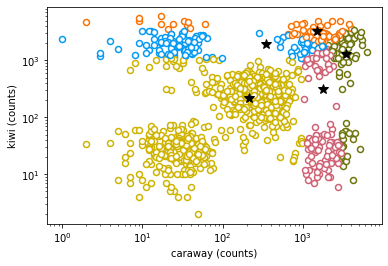

In [5]:
ctype, data, N, G, Q = read_data('w05-data.tbl')
clusters_best, centers_best = k_means(data)
visualize_data(data, centers_best, clusters_best)

Based on the above plot, we were able to reproduce Wiggins' "bad" clustering results. We suspect that this result is most likely to occur because we know that hard k-means is prone to spurious local optima as it assumes that the data is drawn from a Gaussian distribution, which is likely the reason why we are producing these poorly clustered cells.

Knowing that RNA-seq data does not follow a Gaussian distribution due to high expression levels of certain genes given the cell type in our samples, we can consider the possibility that the hard k-means clustering worked as it should, but on a different scale. Lets re-plot the data using non-log scaled axes.

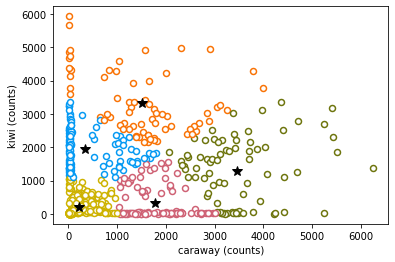

In [6]:
visualize_data(data, centers_best, clusters_best, log_scale = True)

As we suspected, plotting the data on non-log scaled axes puts the centroids in their correct positions, although at this point there are no apparent clusters to the naked eye.

#### 2. Mixture Negative Binomial Fitting

Now that we have some clues as to what might have went wrong with Wiggins' clustering results, lets try a different approach to cluster our read counts for the two genes.

In this approach, we will attempt to utilize a mixture model to fit our single cell RNA-seq read counts to a negative binomial distribution via an expectation maximization (EM) algorithm. While the EM algorithm relies on probability models to cluster the data points, the general steps share much similarity with the hard k-means algorithm, as illustrated through the function definitions shown below.

In [7]:
def expectation(coords, centers, phi, mix_coeffs):
    """
    Perform the expectation step, where we calculate the posterior probabilities 
    and cluster assignments.
    
    Input:
        coords    : the mapped read counts data for the two genes.
        centers   : the centroids based on the estimate of component means.
        phi       : the dispersion parameter.
        mix_coeffs: the mixture coefficient estimates for each component.
    Output:
        log_pgx   : the log-posterior probabilities that each data point comes from 
                    each component.
        clusters  : the current cluster assignment for each data point.
    """
    # initialize all parameters to be calculated as numpy arrays.
    log_pqx = np.zeros((coords.shape[0], len(centers)))
    
    # calculate the log-probability for each data point.
    for i in range(len(centers)):
        for j in range(len(centers[i])):
            log_pqx[:, i] += stats.nbinom.logpmf(coords[:, j], n = 1/phi, p = 1/(1+centers[i, j]*phi))
    log_pqx += np.log(mix_coeffs)
    
    # normalize log-probability to get the posterior probability.
    log_pqx -= logsumexp(log_pqx, axis = 1)[:, np.newaxis]

    # assign each point to a cluster based on the maximum posterior probability.
    clusters = [np.argmax(log_pqx[i]) for i in range(len(coords))]
    
    return log_pqx, clusters


def maximization(coords, log_pqx, mix_coeffs):
    """
    Maximization step, where we calculate the new centroids for each component as 
    the posterior weighted average of the data point positions.
    
    Input:
        coords    : the mapped read counts data for the two genes.
        log_pqx   : the log-posterior probabilities that each data point comes from 
                    each component.
        mix_coeffs: the mixture coefficient estimates for each component.
    Output:
        centers   : the new centroids based on the current estimate of component 
                    means.
        mix_coeffs: the updated mixture coefficient estimates for each component.
    """
    # initialize all parameters to be calculated as numpy arrays.
    num_logmu = np.zeros((len(mix_coeffs), coords.shape[1]))
    denom_logmu = np.zeros((len(mix_coeffs), coords.shape[1]))
    log_w_coord = np.zeros((coords.shape[1], coords.shape[0]))
    log_pqx_t = np.zeros((coords.shape[1], coords.shape[0]))
    
    # calculate the numerator of the weighted means.
    for i in range(len(mix_coeffs)):
        for j in range(len(coords)):
            for k in range(len(coords[j])):
                log_w_coord[k, j] = log_pqx[j, i] + np.log(coords[j, k])
                num_logmu[i, k] = logsumexp(log_w_coord[k])

    # calculate the denominator of the weighted means.
    for i in range(len(mix_coeffs)):
        for j in range(len(coords)):
            for k in range(len(coords[j])):
                log_pqx_t[k, j] = log_pqx[j, i]
                denom_logmu[i, k] = logsumexp(log_pqx_t[k])
                        
    # divide the numerator by denominator to get the weighted means.
    centers = np.exp(num_logmu - denom_logmu)

    # calculate the new mixture coefficients as the mean of the posteriors.
    for i in range(len(centers)):
        mix_coeffs[i] = sum(denom_logmu[i])
    mix_coeffs = mix_coeffs/len(coords)
    
    return centers, mix_coeffs


def negll(coords, centers, phi, mix_coeffs):
    """
    Calculates the negative log-likelihood of data given the current mixture model.
    
    Input:
        coords    : the mapped read counts data for the two genes.
        centers   : the centroids based on the estimate of component means.
        phi       : the dispersion parameter.
        mix_coeffs: the mixture coefficient estimates for each component.
    Output:
        nll       : the negative log likelihood of data given model.
    """
    # initialize all parameters to be calculated as numpy arrays.
    log_prob = np.zeros(len(centers))
    llq = np.zeros(coords.shape[0])

    # calculate the negative log-likelihood as the log-probability mass function 
    # of the data, given the centroid (mu) and phi, plus the log-mixture coefficient.
    for i in range(len(centers)):
        for j in range(len(centers[i])):
            log_prob[i] += stats.nbinom.logpmf(coords[i, j], n = 1/phi, p = 1/(1+centers[i, j]*phi))
    log_prob += np.log(mix_coeffs)
    for i in range(len(coords)): 
        llq[i] = logsumexp(log_prob)
        
    # get the negative log-likelihood.
    nll = -np.sum(llq)
     
    return nll


def em_clust(coords, num_clust = 5, n_runs = 20, phi = 0.3, nll_threshold = 0.0005):
    """
    The EM clustering algorithm.
    
    Input:
        coords       : the mapped read counts data for the two genes.
        num_clust    : the number of clusters.
        n_runs       : the number of iterations to run the clustering algorithm.
        phi          : the dispersion parameter.
        nll_threshold: an arbitrary threshold to determine convergence.
    Output:
        clusters_best: the cluster assignments for each data point from the iteration 
                       that yields the smallest negative log-likelihood.
        centers_best : the best centroid positions for the iteration that yields 
                       the smallest negative log-likelihood.    
    """
    # initialize all parameters to be updated.
    centers_best = []*len(coords)
    nll_best = float('inf')
    mix_coeffs_best = []

    for i in range(n_runs):
        # define a random set of centroids and mixture coeffcients for each iteration.
        mix_coeffs = np.random.rand(num_clust)
        mix_coeffs = np.divide(mix_coeffs, sum(mix_coeffs))
        centers = coords[np.random.choice(coords.shape[0], num_clust, replace = False)]

        # initialize variables that will be updated through each iteration after 
        # the EM model converges.
        nll_diff = float('inf')
        nll_old = float(0)

        # iterate until the differnece between consecutive negative log-likelihoods 
        # are above an arbitrary threshold.
        while nll_diff > (nll_threshold*nll_old):

            # calculate the posterior probabilities and assign data points to their 
            # clusters.
            posts, clusters = expectation(coords, centers, phi, mix_coeffs)

            # calculate the new centroids and mixture coefficients given the current 
            # posterior probabilities.
            centers, mix_coeffs = maximization(coords, posts, mix_coeffs)    

            # calcualte the negative log-likelihood of the current mixture model.
            nll = negll(coords, centers, phi, mix_coeffs)

            # get the difference in consecutive negative log-likelihood values and 
            # update the nll_old.
            nll_diff = abs(nll-nll_old)
            nll_old = nll
            
        # update the best estimates for the centroids, mixture coefficients, and 
        # cluster assignments.
        if nll < nll_best:
            mix_coeffs_best = mix_coeffs
            nll_best = nll
            centers_best = centers
            clusters_best = clusters
            
    return clusters_best, centers_best

After defining the EM clustering algorithm functions, lets run the clustering with Q = 5 components and 20 repetitions with a common dispersion value of ϕ = 0.3. We can then visualize the best clustering results using the clustering repetition that yields in the smallest negative log-likelihood.

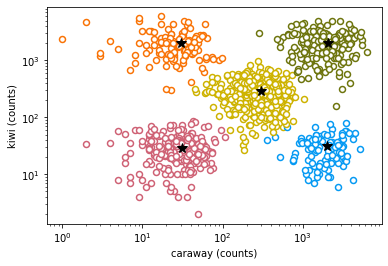

In [8]:
em_clusters_best, em_centers_best = em_clust(data)
visualize_data(data, em_centers_best, em_clusters_best)

Using the determined cell type clusterings from our EM model, we can calculate the estimated mean expression levels of the Caraway and Kiwi genes in the five cell types as well as the relative proportions of each cell type as shown below.

In [9]:
# calculate the estimated mean expression levels for each cluster and the fraction 
# of cells within each cluster.
counts_df = pd.DataFrame(data, columns = ['Caraway','Kiwi'])
counts_df['cluster'] = em_clusters_best
frac_df = (counts_df['cluster'].value_counts()/len(counts_df)).to_frame().rename(columns = {'cluster': 'Fraction'})
counts_df.groupby('cluster').mean().join(frac_df)

,Caraway,Kiwi,Fraction
cluster,,,
0,29.950000,2042.858333,0.120
1,2087.890052,2018.136126,0.191
2,2060.450980,30.362745,0.102
3,31.718310,29.460094,0.213
4,301.339572,294.080214,0.374


#### 3. Find a Simple Fix for K-means

Now that we have resolved the issue of k-means clustering on read count data by utilizing a mixture model approach, we note that the issue of running k-means on right-skewed data could have been resolved by simply log-transforming our read counts as k-means assumes that the data is drawn from a Gaussian distribution. By doing so, we can obtain equally desirable results compared to our EM algorithm as shown below.

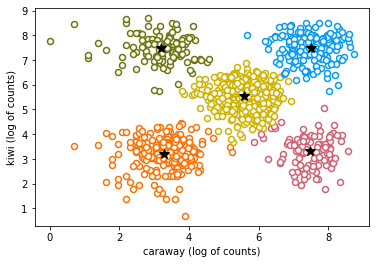

In [10]:
clusters, centroids = k_means(np.log(data))
visualize_data(np.log(data), centroids, clusters, log_scale = True, log_labs = True)